# Projet Recherche Opérationelle - Branch And Bound

## Importation des modules

In [1]:
import numpy as np
import math
import copy

## Structure de données

In [2]:
class Node:
    
    def __init__(self,idx, parent, children, lb, visited):
        self.idx = idx
        self.parent = parent
        self.children = children
        self.lb = lb
        self.visited = visited
        
    def __str__(self):
        return ("\n Index : " +str(self.idx)+
                "\n Parent : " +str(self.parent)+
                "\n Children : "+str(self.children) + 
                "\n lb : "+str(self.lb)+ 
                "\n visited : "+str(self.visited))

In [3]:
def arborescence(node,Tree):
    branch = []
    while node.parent != None:
        branch.append(node)
        node = Tree[node.parent]
    branch.append(node)
    
    return branch

In [4]:
#Textbook Example
pj = [12,8,15,9]
dj = [16,26,25,27]
wj = [4,5,3,5]

In [5]:
def computeCost(p,d,w,order):
    t=0
    cost=0
    for idx in order:
        t += p[idx]
        cost += max(0,(t-d[idx])*w[idx])
    return cost

In [6]:
computeCost(pj,dj,wj,[0,1,3,2])

67

In [7]:
def getPrimal_0(p,d,w):
    sortedTasks=(np.argsort((np.array(d)-np.array(p))*np.array(w)))[::-1]
    cost=computeCost(p,d,w,sortedTasks)
    return(cost,sortedTasks)

def getPrimal_1(p,d,w):
    sortedTasks=np.argsort(d)
    cost=computeCost(p,d,w,sortedTasks)
    return(cost,sortedTasks)

def getPrimal_2(p,d,w):
    tasksLeft=[int(i) for i in range(len(p))]
    order=[]
    while len(tasksLeft)!= 0:
        time=np.sum(np.array(p)[tasksLeft])
        penalities=(time-np.array(d)[tasksLeft])*np.array(w)[tasksLeft]
        sortedTasks=np.argsort(penalities)
        order.append(tasksLeft[sortedTasks[0]])
        tasksLeft.pop(sortedTasks[0])
    order.reverse()
    cost = computeCost(p,d,w,order)
    return(cost,order)

In [8]:
print("Temps production : ", pj)
print("Date limite :      ", dj)
print("Pénalités :        ", wj)
print("0 : ",getPrimal_0(pj,dj,wj))
print("1 : ",getPrimal_1(pj,dj,wj))
print("2 : ",getPrimal_2(pj,dj,wj))

Temps production :  [12, 8, 15, 9]
Date limite :       [16, 26, 25, 27]
Pénalités :         [4, 5, 3, 5]
0 :  (133, array([3, 1, 2, 0], dtype=int64))
1 :  (136, array([0, 2, 1, 3], dtype=int64))
2 :  (67, [0, 1, 3, 2])


In [9]:
def getDual_0(p,d,w,visited):
    dual=0
    time=0
    notVisited=list(range(len(p)))
    for i in visited:
        retard=((p[i]+time)-d[i])
        dual+=retard*w[i]*(retard>0)
        time+=p[i]
        notVisited.remove(i)
        
    for j in notVisited:
        retard=(p[j]+time)-d[j]
        dual+=retard*w[j]*(retard>0)
    return dual

def getDual_1(p,d,w,visited):
    dual=0
    time=0
    notVisited=list(range(len(p)))
    for i in visited:
        retard=((p[i]+time)-d[i])
        dual+=retard*w[i]*(retard>0)
        time+=p[i]
        notVisited.remove(i)
        
    return dual

def getDual_2(p,d,w,visited):
    dual=0
    time=np.sum(p)

    for i in visited:
        retard=(time-d[i])
        dual+=retard*w[i]*(retard>0)
        time-=p[i]
        
    return dual

In [10]:
print("Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces et on ajoute les pénalités des autres pièces en supposant qu'elles sont en (k+1)ème position : \n",
      getDual_0(pj,dj,wj,[2,3]))
print("Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces : \n",
      getDual_1(pj,dj,wj,[2,3]))

Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces et on ajoute les pénalités des autres pièces en supposant qu'elles sont en (k+1)ème position : 
 110
Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces : 
 0


In [11]:
def exploration_0(Queue,Tree,UB):
    return(Queue[0])

def exploration_1(Queue,Tree,UB):
    return(Queue[-1])

def exploration_2(Queue,Tree,UB):
    bestNode = None
    bestLB = -math.inf
    for i in range(len(Queue)):
        if Tree[Queue[i]].lb > bestLB and Tree[Queue[i]].lb < UB:
            bestLB = Tree[Queue[i]].lb
            bestNode = i
    return(Queue[i])

# Branch and Bound

In [12]:
def branch_and_bound_display(p,d,w,byLast,getPrimal,getDual,exploration,steps):
    
    Tasks = list(range(len(p)))
    Tree = [] # list of all nodes created (a list of Node objects)
    Queue = [] # list of nodes to process (a list of integers with the index of nodes to process in the Tree)
    UB = 10000000 # set the upper bound to a sufficiently large number
    LB = 0 # set the lower bound to a sufficiently small number 
    
    UB,currentOrder = getPrimal(p,d,w)
    if steps:
        print("First UB : ", UB)
    
    root = Node(0,None, [], 0, []) # at the root node no variables are fixed 
    Tree.append(root) # start the tree with the root node
    Queue.append(0) # start the list of nodes to process with the root node
    
    #continue processing nodes until the queue is empty
    
    nbIterations = 0
    
    while Queue!=[]:
        

        # process the first node in the queue

        currentIndex = exploration(Queue,Tree,UB)
        currentNode = Tree[currentIndex]
        nbIterations +=1
        
        if nbIterations == 1e4:
            print("UB : ", UB)
            print(currentNode)
        if nbIterations == 2e5:
            print("UB : ", UB)
            print(currentNode)
        if nbIterations == 2e5:
            print("UB : ", UB)
            print(currentNode)
        
        if steps:
            print("##################################")
            print("Current Node : {}\n".format(currentIndex),currentNode )
        
        if len(currentNode.visited) == len(p):
            order = copy.copy(currentNode.visited)
            if byLast:
                order.reverse()
            solutionCost = computeCost(p,d,w,order)
            if solutionCost <= UB:
                UB = solutionCost
                currentOrder=order
                
        if currentNode.lb < UB:
            for nextTask in (set(Tasks)-set(currentNode.visited)):
                nextVisited = copy.copy(currentNode.visited)
                nextVisited.append(nextTask)
                nextLb = getDual(p,d,w, nextVisited)
                
                newNode = Node(len(Tree)-1,currentIndex, [], nextLb,nextVisited)
                Tree.append(newNode)
                Queue.append(len(Tree)-1)
                currentNode.children.append(len(Tree)-1)
        else:
            if steps:
                print("Prune : ", currentIndex)
        
        # Calculate the current LB as the maximum of all the upper bounds among the active nodes
        currentLB = -math.inf
        for node in Tree:
            if node.lb > currentLB and node.lb <= UB:
                currentLB = node.lb
        
        # Update the LB if the current LB is better
        if currentLB >= LB:
            LB = currentLB
        
        # Display the current upper and lower bounds    
        if steps:
            print("LB= ",LB," UB= ", UB)
        # When the processing of the node is completed remove the node from the queue     
        Queue.remove(currentIndex)

    # return the  solution
    print("Number of iterations : ", nbIterations)
    
    return UB, currentOrder

In [13]:
def branch_and_bound(p,d,w,byLast,getPrimal,getDual,exploration):
    
    Tasks = list(range(len(p)))
    Tree = [] # list of all nodes created (a list of Node objects)
    Queue = [] # list of nodes to process (a list of integers with the index of nodes to process in the Tree)
    UB = 10000000 # set the upper bound to a sufficiently large number
    LB = 0 # set the lower bound to a sufficiently small number 
    
    UB,currentOrder = getPrimal(p,d,w)

    bestNode = Node(-1,-1, [], 0 ,[])
    
    root = Node(0,None, [], 0, []) # at the root node no variables are fixed 
    Tree.append(root) # start the tree with the root node
    Queue.append(0) # start the list of nodes to process with the root node
    
    #continue processing nodes until the queue is empty
    
    nbIterations = 0
    
    while Queue!=[]:
        
        # process the first node in the queue

        currentIndex = exploration(Queue,None,None)
        currentNode = Tree[currentIndex]
        nbIterations +=1
        
        if currentNode.lb < UB:
            
            if len(currentNode.visited) == len(p):
                order = copy.copy(currentNode.visited)
                if byLast:
                    order.reverse()
                solutionCost = computeCost(p,d,w,order)
                if solutionCost <= UB:
                    UB = solutionCost
                    currentOrder=order
                    bestNode = currentNode
            else:
                for nextTask in (set(Tasks)-set(currentNode.visited)):
                    nextVisited = copy.copy(currentNode.visited)
                    nextVisited.append(nextTask)
                    nextLb = getDual(p,d,w, nextVisited)

                    newNode = Node(len(Tree),currentIndex, [], nextLb,nextVisited)
                    Tree.append(newNode)
                    Queue.append(len(Tree)-1)
                    currentNode.children.append(len(Tree)-1)
            
        # When the processing of the node is completed remove the node from the queue     
        Queue.remove(currentIndex)

    # return the  solution
    
    if 2*(UB-bestNode.lb)/(UB+bestNode.lb)<=0.0001:
        branch = arborescence(bestNode,Tree)
    else:
        bestLB = -math.inf
        for node in Tree:
            if node.lb > bestLB and node.lb <=UB:
                bestLB = node.lb
                bestNode=node
        branch = arborescence(bestNode,Tree)

    return UB, currentOrder, nbIterations, branch, Tree

In [14]:
#Textbook Example
pj = [12,8,15,9]
dj = [16,26,25,27]
wj = [4,5,3,5]

In [15]:
solution, order, nbIterations, branch, Tree = branch_and_bound(pj,dj,wj, False, getPrimal_1, getDual_1,exploration_1)
print(nbIterations)
solution, order, nbIterations, branch, Tree = branch_and_bound(pj,dj,wj, False, getPrimal_2, getDual_1,exploration_1)
print(nbIterations)
solution, order, nbIterations, branch, Tree = branch_and_bound(pj,dj,wj, True, getPrimal_1, getDual_2,exploration_0)
print(nbIterations)
solution, order, nbIterations, branch, Tree = branch_and_bound(pj,dj,wj, True, getPrimal_1, getDual_2,exploration_1)
print(nbIterations)
solution, order, nbIterations, branch, Tree = branch_and_bound(pj,dj,wj, True, getPrimal_0, getDual_2,exploration_0)
print(nbIterations)
solution, order, nbIterations, branch, Tree = branch_and_bound(pj,dj,wj, True, getPrimal_0, getDual_2,exploration_1)
print(nbIterations)
solution, order, nbIterations, branch, Tree = branch_and_bound(pj,dj,wj, True, getPrimal_2, getDual_2,exploration_0)
print(nbIterations)
solution, order, nbIterations, branch, Tree = branch_and_bound(pj,dj,wj, True, getPrimal_2, getDual_2,exploration_1)
print(nbIterations)

65
59
44
17
38
17
8
8


## Test de notre fonction Branch-And-Bound : 

In [16]:
def genInstancies(n):
    p=np.random.randint(1,15,n)
    d=np.random.randint(3,int(0.5*n*15),n)
    w=np.random.randint(1,5,n)
    return(p,d,w)

In [17]:
p,d,w = genInstancies(4)
print("p : ", p)
print("d : ", d)
print("w : ", w)
solution, order, nbIterations, branch, tree = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
print("Final Results: {} Iterations".format(nbIterations))
print("Order : {} | Cost : {}".format(order,computeCost(p,d,w,order)))

p :  [11  6  9  8]
d :  [14 17 17 26]
w :  [4 4 3 1]
Final Results: 8 Iterations
Order : [0, 1, 2, 3] | Cost : 35


In [18]:
branch

## Visualisation

In [23]:
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import networkx as nx
import matplotlib.pyplot as plt

In [24]:
#Textbook Example
pj = [12,8,15,9]
dj = [16,26,25,27]
wj = [4,5,3,5]
solution, order, nbIterations, branch, Tree = branch_and_bound(pj,dj,wj, True, getPrimal_2, getDual_2,exploration_1)

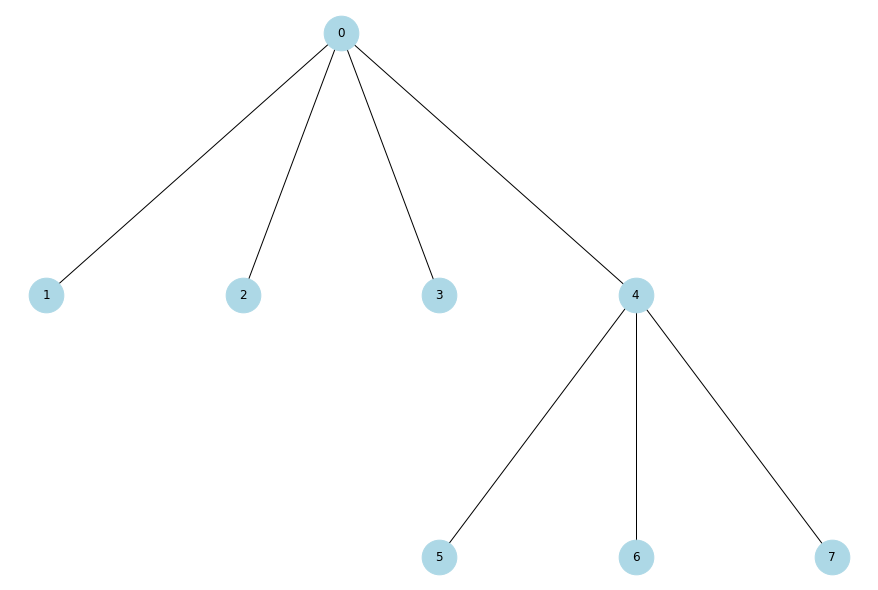

In [37]:
index = [node.idx for node in tree]
mygraph=nx.Graph()
mygraph.add_nodes_from(index)
for node in tree:
    if node.parent != None:
        mygraph.add_edge(node.idx, node.parent)

#for i in range(len(branch)-1):
    #mygraph.add_edge(branch[i].idx,branch[i+1].idx,color='r',weight=2)
    
plt.figure(figsize=(12,8))
pos = graphviz_layout(mygraph, prog="dot")
nx.draw(mygraph, pos,with_labels=True,node_size=1200,node_color="lightblue")
plt.show()